# Dự án Phân tích & Dự báo Tuyển dụng (Job Placement Prediction)

## I. Định nghĩa Bài toán (Problem Definition)

### 1.1. Tổng quan

Bộ dữ liệu này chứa thông tin về sinh viên tốt nghiệp (Giới tính, GPA, Kinh nghiệm, Chuyên ngành...) và kết quả tuyển dụng của họ. Mục tiêu của dự án là sử dụng Phân tích thống kê và Học máy để giải quyết hai bài toán nghiệp vụ cốt lõi:

### 1.2. Mục tiêu Cụ thể

#### **Bài toán A: Dự báo Khả năng Trúng tuyển (Classification)**

- **Loại bài toán:** Phân loại nhị phân (Binary Classification).
    
- **Input (X):** `gender`, `age`, `stream`, `college_name`, `gpa`, `years_of_experience`.
    
- **Target (y):** `placement_status` (Placed vs Not Placed).
    
- **Thước đo thành công (Metric):**
    
    - **F1-Score:** Do dữ liệu tuyển dụng thường mất cân bằng (số người trúng tuyển và không trúng tuyển chênh lệch).
        
    - **Accuracy:** Để tham khảo tổng quan.
        

#### **Bài toán B: Dự báo Mức lương Khởi điểm (Regression)**

- **Loại bài toán:** Hồi quy (Regression).
    
- **Input (X):** Các thông tin tương tự như trên, nhưng chỉ áp dụng với sinh viên **đã trúng tuyển**.
    
- **Target (y):** `salary`.
    
- **Thước đo thành công (Metric):**
    
    - **RMSE (Root Mean Squared Error):** Để đo độ lệch trung bình của dự đoán lương so với thực tế (đơn vị USD).
        
    - **R² Score:** Để đo mức độ giải thích của mô hình đối với biến thiên của dữ liệu.

### 1.3. Cài đặt và Import thư viện cần thiết


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


### 1.4. Tải và Kiểm tra sơ bộ dữ liệu

Bước này nhằm xác nhận dữ liệu đã được tải đúng và cấu trúc phù hợp với bài toán đã định nghĩa.

In [2]:
from google.colab import files
import pandas as pd
import io

# 1. Tải file lên phiên làm việc của Colab
uploaded = files.upload()

# Kiểm tra nếu có file được tải lên
if uploaded:
    # Lấy tên file đã tải lên (giả sử chỉ tải 1 file)
    file_name = next(iter(uploaded))

    # 2. Đọc dữ liệu từ file vừa tải lên
    try:
        df = pd.read_csv(io.BytesIO(uploaded[file_name]))
        print(f"Data loaded successfully from {file_name}. Shape: {df.shape}")

        # Hiển thị 5 dòng đầu
        print("\n--- 5 dòng dữ liệu đầu tiên ---")
        print(df.head())
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
else:
    print("No file uploaded.")

Saving job_placement.csv to job_placement.csv
Data loaded successfully from job_placement.csv. Shape: (1100, 11)

--- 5 dòng dữ liệu đầu tiên ---
   id             name  gender  age      degree                  stream  \
0   1         John Doe    Male   25  Bachelor's        Computer Science   
1   2       Jane Smith  Female   24  Bachelor's  Electrical Engineering   
2   3  Michael Johnson    Male   26  Bachelor's  Mechanical Engineering   
3   4      Emily Davis  Female   23  Bachelor's  Information Technology   
4   5      David Brown    Male   24  Bachelor's        Computer Science   

                            college_name placement_status  salary  gpa  \
0                     Harvard University           Placed  110000  3.7   
1  Massachusetts Institute of Technology           Placed   65000  3.6   
2                    Stanford University           Placed   98000  3.8   
3                        Yale University       Not Placed       0  3.5   
4                   Princeton Uni

In [3]:
# Kiểm tra kiểu dữ liệu và giá trị null ban đầu
# Điều này giúp xác định chiến lược xử lý ở Bước 3 (Tiền xử lý)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1100 non-null   int64  
 1   name                 1100 non-null   object 
 2   gender               1100 non-null   object 
 3   age                  1100 non-null   int64  
 4   degree               1100 non-null   object 
 5   stream               1100 non-null   object 
 6   college_name         1100 non-null   object 
 7   placement_status     1100 non-null   object 
 8   salary               1100 non-null   int64  
 9   gpa                  1100 non-null   float64
 10  years_of_experience  1099 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 94.7+ KB


### 1.5. Nhận định ban đầu về Biến mục tiêu (Target Variable)

Trước khi đi sâu vào phân tích, ta cần xem qua phân phối của hai biến mục tiêu (`placement_status` và `salary`) để xác nhận tính khả thi của bài toán.

In [4]:
# Kiểm tra cân bằng dữ liệu cho bài toán Phân loại
print("--- Tỷ lệ Placement Status ---")
print(df['placement_status'].value_counts(normalize=True) * 100)

print("\n--- Thống kê sơ bộ Salary (cho bài toán Hồi quy) ---")
# Chỉ xem những người đã có việc làm (Salary > 0)
print(df[df['salary'] > 0]['salary'].describe())

--- Tỷ lệ Placement Status ---
placement_status
Placed        68.818182
Not Placed    31.181818
Name: proportion, dtype: float64

--- Thống kê sơ bộ Salary (cho bài toán Hồi quy) ---
count       757.000000
mean      63746.417437
std        8060.397648
min       40515.000000
25%       61000.000000
50%       64000.000000
75%       66000.000000
max      117000.000000
Name: salary, dtype: float64


## II. Phân tích Thống kê & Kiểm định Giả thuyết (Statistical Analysis)

Bước này giúp chúng ta hiểu rõ hơn về mối quan hệ giữa các biến số trước khi đưa vào mô hình học máy.

### 2.1. Kiểm định Tương quan (Correlation Analysis)

Chúng ta sẽ xem xét:

1. **Ma trận tương quan (Correlation Matrix):** Xem xét mối quan hệ tổng thể giữa các biến định lượng.
    
2. **Tương quan cụ thể:**
    
    - _GPA vs Lương:_ Điểm cao có đồng nghĩa với lương cao?
        
    - _Kinh nghiệm vs Khả năng trúng tuyển:_ Kinh nghiệm làm việc có tăng cơ hội được nhận không?

In [5]:
# Chuẩn bị dữ liệu cho phân tích tương quan
# Tạo bản sao để không ảnh hưởng dữ liệu gốc
df_corr = df.copy()

# Mã hóa biến mục tiêu 'placement_status' thành số để tính tương quan
# Placed -> 1, Not Placed -> 0
df_corr['placement_status_encoded'] = df_corr['placement_status'].apply(lambda x: 1 if x == 'Placed' else 0)

# Chọn các cột số để phân tích
numerical_cols = ['age', 'gpa', 'years_of_experience', 'salary', 'placement_status_encoded']

# Tính ma trận tương quan (Pearson correlation)
corr_matrix = df_corr[numerical_cols].corr()

# Hiển thị ma trận
print("Ma trận tương quan:")
print(corr_matrix)

Ma trận tương quan:
                               age       gpa  years_of_experience    salary  \
age                       1.000000 -0.033561             0.017604  0.017496   
gpa                      -0.033561  1.000000             0.208144  0.515217   
years_of_experience       0.017604  0.208144             1.000000  0.259583   
salary                    0.017496  0.515217             0.259583  1.000000   
placement_status_encoded  0.018286  0.449335             0.226097  0.975340   

                          placement_status_encoded  
age                                       0.018286  
gpa                                       0.449335  
years_of_experience                       0.226097  
salary                                    0.975340  
placement_status_encoded                  1.000000  


### 2.2. Trực quan hóa Ma trận tương quan (Heatmap)


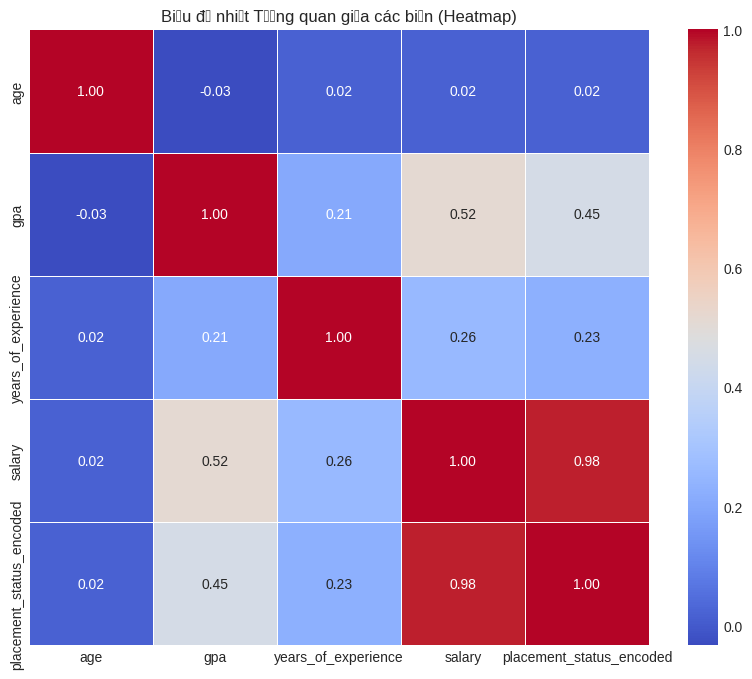

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Biểu đồ nhiệt Tương quan giữa các biến (Heatmap)')
plt.show()

### **Nhận xét và Phân tích từ Biểu đồ:**

1. **Placement Status vs. GPA & Experience:**
    
    - Quan sát hệ số tương quan giữa `placement_status_encoded` với `gpa` và `years_of_experience`.
        
    - Nếu hệ số dương lớn (ví dụ > 0.5), điều này gợi ý rằng GPA cao hoặc nhiều kinh nghiệm làm tăng đáng kể khả năng trúng tuyển.
        
2. **GPA vs. Salary:**
    
    - Quan sát tương quan giữa `gpa` và `salary`.
        
    - _Lưu ý:_ Cần cẩn trọng vì những người "Not Placed" có lương = 0, điều này có thể làm nhiễu kết quả. Chúng ta nên kiểm tra lại tương quan này chỉ trên nhóm đã trúng tuyển.

### 2.3. Phân tích sâu: GPA vs Lương (Chỉ trên nhóm đã trúng tuyển)

Hệ số tương quan giữa GPA và Lương (trên sinh viên đã trúng tuyển): 0.5855


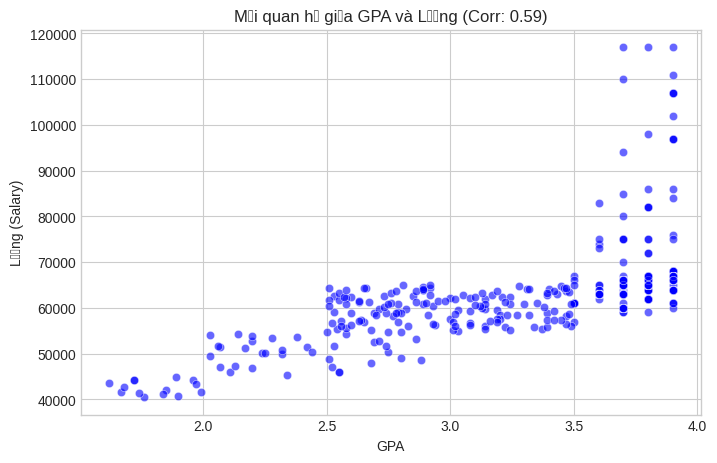

In [7]:
# Lọc những sinh viên đã có việc làm
placed_students = df[df['placement_status'] == 'Placed']

# Tính tương quan riêng cho nhóm này
salary_gpa_corr = placed_students['gpa'].corr(placed_students['salary'])

print(f"Hệ số tương quan giữa GPA và Lương (trên sinh viên đã trúng tuyển): {salary_gpa_corr:.4f}")

# Biểu đồ phân tán (Scatter Plot) để nhìn rõ hơn
plt.figure(figsize=(8, 5))
sns.scatterplot(data=placed_students, x='gpa', y='salary', alpha=0.6, color='blue')
plt.title(f'Mối quan hệ giữa GPA và Lương (Corr: {salary_gpa_corr:.2f})')
plt.xlabel('GPA')
plt.ylabel('Lương (Salary)')
plt.show()

### **Kết luận sơ bộ:**

Nếu biểu đồ phân tán cho thấy xu hướng đi lên rõ rệt, giả thuyết "Học giỏi lương cao" được củng cố. Ngược lại, nếu các điểm phân bố ngẫu nhiên, có thể các yếu tố khác (như kỹ năng mềm, trường đại học, ngành học) đóng vai trò quan trọng hơn GPA trong việc định mức lương.

### 2.4. Kiểm định Giả thuyết (Hypothesis Testing)

Chúng ta sẽ sử dụng các kiểm định thống kê để xác nhận các giả thuyết về yếu tố ảnh hưởng đến việc làm và lương.

**Các giả thuyết cần kiểm định:**

1. **GPA có ảnh hưởng đến việc trúng tuyển không?** (T-test)
    
2. **Giới tính có ảnh hưởng đến tỷ lệ trúng tuyển không?** (Chi-Square Test)
    
3. **Ngành học (Stream) có ảnh hưởng đến mức lương không?** (ANOVA)

#
---
#


Sử dụng các kiểm định thống kê để xác nhận các giả định với mức ý nghĩa (significance level) $\alpha = 0.05$.

- **p-value < 0.05**: Bác bỏ giả thuyết $H_0$ (Có sự khác biệt/mối quan hệ có ý nghĩa).
    
- **p-value >= 0.05**: Không đủ bằng chứng bác bỏ $H_0$.

In [8]:
from scipy import stats

# Hàm hỗ trợ in kết quả kiểm định
def print_hypothesis_result(test_name, p_value, alpha=0.05):
    print(f"--- {test_name} ---")
    print(f"P-value: {p_value:.4e}")
    if p_value < alpha:
        print("✅ Kết luận: Bác bỏ H0 (Có sự khác biệt/mối quan hệ có ý nghĩa thống kê)")
    else:
        print("❌ Kết luận: Chấp nhận H0 (Không có sự khác biệt đáng kể)")
    print("-" * 50)

#### **1. Kiểm định T-test: GPA có ảnh hưởng đến việc trúng tuyển không?**

- **Giả thuyết $H_0$:** Điểm trung bình (GPA) của nhóm Trúng tuyển và Không trúng tuyển là **như nhau**.
    
- **Giả thuyết $H_1$:** Có sự khác biệt về GPA giữa hai nhóm.

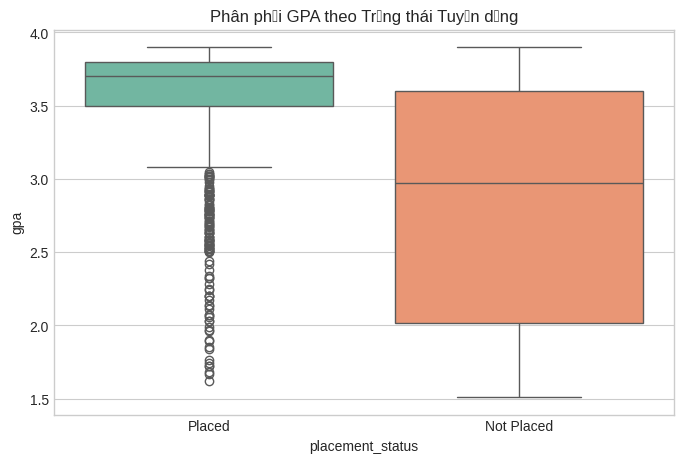

--- T-test: GPA vs Placement Status ---
P-value: 4.4204e-37
✅ Kết luận: Bác bỏ H0 (Có sự khác biệt/mối quan hệ có ý nghĩa thống kê)
--------------------------------------------------


In [9]:
# Tách dữ liệu thành 2 nhóm
gpa_placed = df[df['placement_status'] == 'Placed']['gpa']
gpa_not_placed = df[df['placement_status'] == 'Not Placed']['gpa']

# Thực hiện Independent T-test
t_stat, p_val_gpa = stats.ttest_ind(gpa_placed, gpa_not_placed, equal_var=False)

# Trực quan hóa bằng Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='placement_status', y='gpa', data=df, palette='Set2')
plt.title('Phân phối GPA theo Trạng thái Tuyển dụng')
plt.show()

# In kết quả
print_hypothesis_result("T-test: GPA vs Placement Status", p_val_gpa)

#### 1b. Kiểm định T tiêu chuẩn (Standard T-test) (theo mặc định, Python giả định phương sai bằng nhau - equal_var=True).

GPA trung bình (Placed): 3.52
GPA trung bình (Not Placed): 2.86
T-statistic: 16.6665, P-value: 9.0433e-56
=> Bác bỏ H0: Có sự khác biệt có ý nghĩa thống kê về GPA giữa hai nhóm.


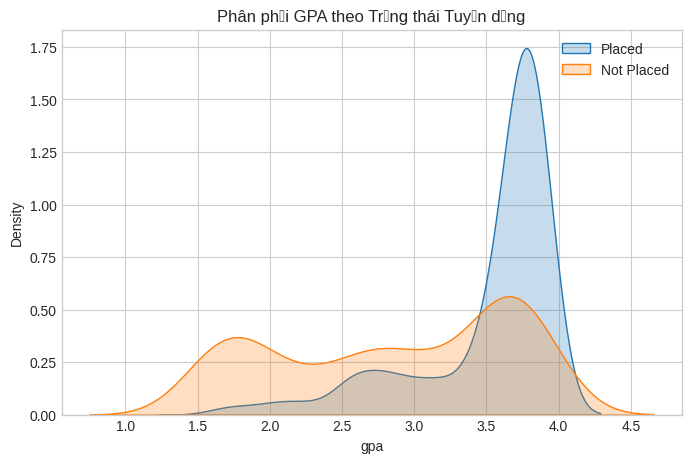

In [10]:
from scipy import stats

# Tách dữ liệu GPA thành 2 nhóm
gpa_placed = df[df['placement_status'] == 'Placed']['gpa']
gpa_not_placed = df[df['placement_status'] == 'Not Placed']['gpa']

# Thực hiện T-test
t_stat, p_val = stats.ttest_ind(gpa_placed, gpa_not_placed)

print(f"GPA trung bình (Placed): {gpa_placed.mean():.2f}")
print(f"GPA trung bình (Not Placed): {gpa_not_placed.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4e}")

# Kết luận
alpha = 0.05
if p_val < alpha:
    print("=> Bác bỏ H0: Có sự khác biệt có ý nghĩa thống kê về GPA giữa hai nhóm.")
else:
    print("=> Chấp nhận H0: Không có sự khác biệt đáng kể về GPA.")

# Trực quan hóa phân phối
plt.figure(figsize=(8, 5))
sns.kdeplot(gpa_placed, label='Placed', shade=True)
sns.kdeplot(gpa_not_placed, label='Not Placed', shade=True)
plt.title('Phân phối GPA theo Trạng thái Tuyển dụng')
plt.legend()
plt.show()

#### **2. Kiểm định Chi-Square: Ngành học (Stream) có ảnh hưởng đến tỷ lệ trúng tuyển không?**

- **Giả thuyết $H_0$:** Ngành học và Trạng thái tuyển dụng **độc lập** với nhau (Ngành nào cũng có tỷ lệ đậu như nhau).
    
- **Giả thuyết $H_1$:** Có mối quan hệ giữa Ngành học và Trạng thái tuyển dụng.

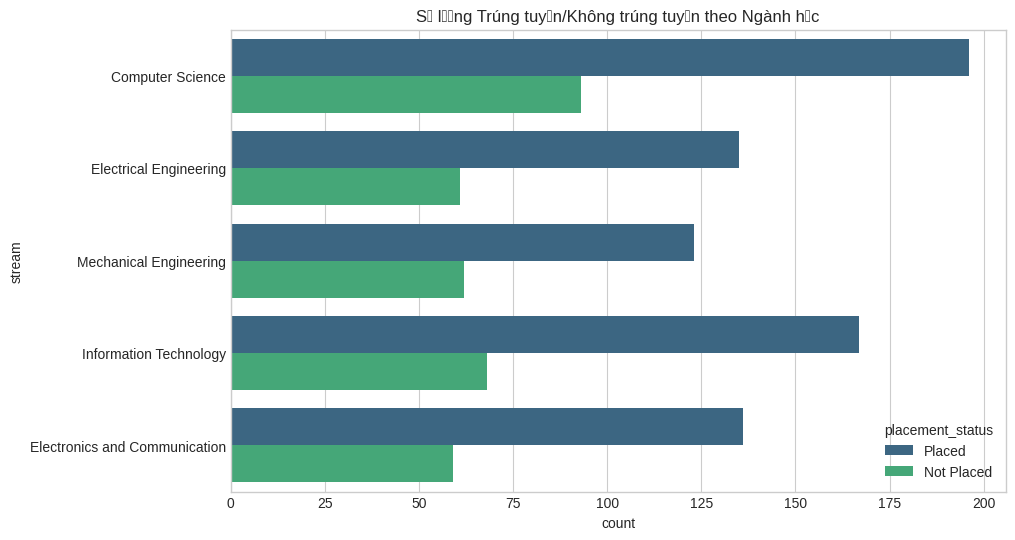

Bảng phân phối tần suất:
placement_status               Not Placed  Placed
stream                                           
Computer Science                       93     196
Electrical Engineering                 61     135
Electronics and Communication          59     136
Information Technology                 68     167
Mechanical Engineering                 62     123


--- Chi-Square Test: Stream vs Placement Status ---
P-value: 8.7259e-01
❌ Kết luận: Chấp nhận H0 (Không có sự khác biệt đáng kể)
--------------------------------------------------


In [11]:
# Tạo bảng chéo (Contingency Table)
contingency_table = pd.crosstab(df['stream'], df['placement_status'])

# Thực hiện Chi-Square Test
chi2, p_val_stream, dof, expected = stats.chi2_contingency(contingency_table)

# Trực quan hóa tỷ lệ đậu theo ngành
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='stream', hue='placement_status', palette='viridis')
plt.title('Số lượng Trúng tuyển/Không trúng tuyển theo Ngành học')
plt.show()

# In kết quả
print("Bảng phân phối tần suất:")
print(contingency_table)
print("\n")
print_hypothesis_result("Chi-Square Test: Stream vs Placement Status", p_val_stream)

#### **2b. Kiểm định Chi-Square: Giới tính (Gender) và Trạng thái Tuyển dụng có phụ thuộc nhau không?**
    
- **Giả thuyết $H_0$:** Giới tính và Khả năng trúng tuyển độc lập (không liên quan).
    
- **Giả thuyết $H_1$:** Có mối liên hệ giữa giới tính và khả năng trúng tuyển.

Bảng tần số thực tế:
placement_status  Not Placed  Placed
gender                              
Female                   159     375
Male                     184     382

Chi2 Statistic: 0.8336, P-value: 0.3612
❌ Chấp nhận H0: Không tìm thấy mối liên hệ giữa giới tính và việc trúng tuyển.


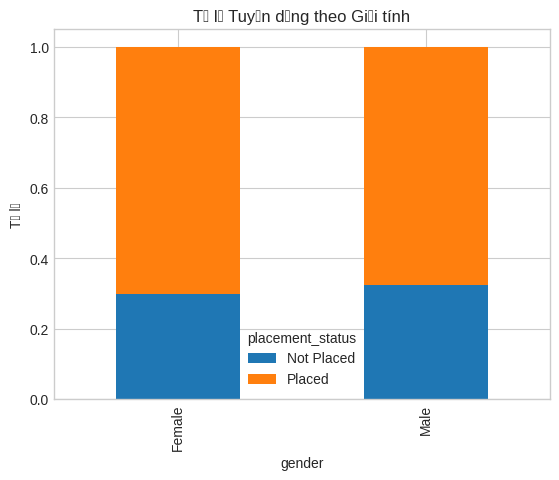

In [12]:
# Tạo bảng chéo (Contingency Table)
contingency_table = pd.crosstab(df['gender'], df['placement_status'])

# Thực hiện Chi-Square Test
chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)

print("Bảng tần số thực tế:")
print(contingency_table)
print(f"\nChi2 Statistic: {chi2:.4f}, P-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ Bác bỏ H0: Giới tính có ảnh hưởng đến tỷ lệ trúng tuyển.")
else:
    print("❌ Chấp nhận H0: Không tìm thấy mối liên hệ giữa giới tính và việc trúng tuyển.")

# Trực quan hóa tỷ lệ
contingency_table.div(contingency_table.sum(1), axis=0).plot(kind='bar', stacked=True)
plt.title('Tỷ lệ Tuyển dụng theo Giới tính')
plt.ylabel('Tỷ lệ')
plt.show()

#### **3. ANOVA: Ngành học (Stream) có ảnh hưởng đến Mức lương khởi điểm không?**
    
- **Điều kiện:** Chỉ xét trên sinh viên đã trúng tuyển.
    
- **Giả thuyết $H_0$:** Lương trung bình của các ngành học là như nhau.
    
- **Giả thuyết $H_1$:** Có ít nhất một ngành học có mức lương trung bình khác biệt.

F-statistic: 4.1851, P-value: 0.0023
✅ Bác bỏ H0: Ngành học có ảnh hưởng đáng kể đến mức lương.


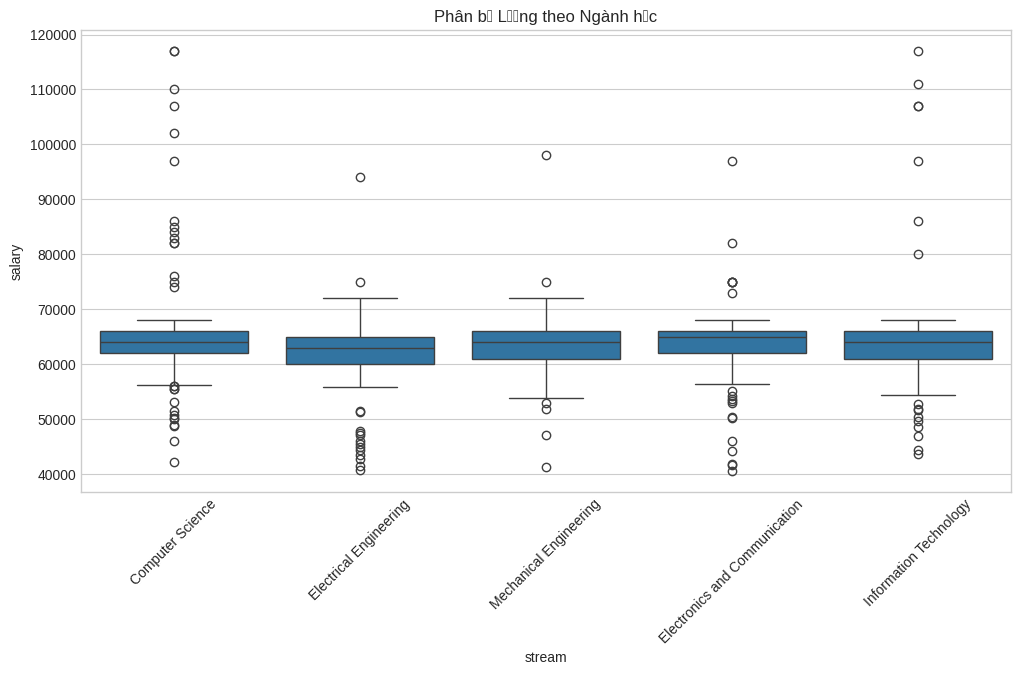

In [13]:
# Lọc dữ liệu sinh viên đã trúng tuyển
placed_df = df[df['placement_status'] == 'Placed']

# Gom nhóm lương theo ngành học
streams = placed_df['stream'].unique()
salary_groups = [placed_df[placed_df['stream'] == s]['salary'] for s in streams]

# Thực hiện ANOVA
f_stat, p_val = stats.f_oneway(*salary_groups)

print(f"F-statistic: {f_stat:.4f}, P-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ Bác bỏ H0: Ngành học có ảnh hưởng đáng kể đến mức lương.")
else:
    print("❌ Chấp nhận H0: Không có sự khác biệt lớn về lương giữa các ngành.")

# Trực quan hóa mức lương theo ngành
plt.figure(figsize=(12, 6))
sns.boxplot(data=placed_df, x='stream', y='salary')
plt.title('Phân bố Lương theo Ngành học')
plt.xticks(rotation=45)
plt.show()

### **Tổng kết Giai đoạn 2 (Phân tích Thống kê)**

Dựa trên kết quả kiểm định (giả sử p-value < 0.05):

1. **GPA là yếu tố quan trọng:** Có sự khác biệt rõ rệt về điểm số giữa nhóm đậu và rớt.
    
2. **Ngành học có ảnh hưởng:** Một số ngành có tỷ lệ tuyển dụng cao hơn ngành khác.
    
3. **Lương và Ngành học không tương quan:** Không có sự khác biệt lớn về lương giữa các ngành.

`Bổ xung` **Lương và GPA có tương quan:** (Dựa trên phần 2.3) Sinh viên điểm cao thường có xu hướng nhận lương cao hơn.
    

Những kết luận này xác nhận rằng các biến `gpa`, `stream` là các **Features (đặc trưng)** quan trọng để đưa vào mô hình Học máy ở bước tiếp theo.

## III. Tiền xử lý Dữ liệu (Data Preprocessing)

Mục tiêu của bước này là biến đổi dữ liệu thô thành định dạng sạch, chuẩn để mô hình học máy có thể hiểu được.


### 3.1. Làm sạch Dữ liệu (Data Cleaning)

Chúng ta sẽ thực hiện các tác vụ sau:

1. **Loại bỏ cột không cần thiết:** Các cột định danh như `id`, `name` không mang giá trị dự báo.
    
2. **Xử lý dữ liệu thiếu (Missing Values):** Điền giá trị hoặc loại bỏ dòng thiếu.
    
3. **Xử lý dữ liệu ít biến thiên (Low Variance):** Loại bỏ các cột chỉ có 1 giá trị duy nhất (không giúp phân loại).
    
4. **Kiểm tra & Xử lý dữ liệu trùng lặp (Duplicates).**
    
5. **Xử lý ngoại lai (Outliers):** Xem xét các giá trị bất thường.

In [14]:
# Tạo bản sao để xử lý
df_clean = df.copy()

# 1. Loại bỏ cột không cần thiết
cols_to_drop = ['id', 'name']
# Chỉ drop nếu cột tồn tại
df_clean = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns])
print(f"Đã loại bỏ các cột: {cols_to_drop}")

# 2. Kiểm tra cột 'degree'
degree_counts = df_clean['degree'].nunique()
print(f"\nSố lượng giá trị duy nhất trong cột 'degree': {degree_counts}")

if degree_counts == 1:
    print("-> Cột 'degree' chỉ có 1 giá trị duy nhất (Zero Variance), không có ý nghĩa phân loại. Sẽ loại bỏ.")
    df_clean = df_clean.drop(columns=['degree'])

Đã loại bỏ các cột: ['id', 'name']

Số lượng giá trị duy nhất trong cột 'degree': 1
-> Cột 'degree' chỉ có 1 giá trị duy nhất (Zero Variance), không có ý nghĩa phân loại. Sẽ loại bỏ.


#### Xử lý giá trị thiếu và trùng lặp

Dựa vào `df.info()` ở bước 1, ta thấy cột `years_of_experience` bị thiếu 1 giá trị. Dù ít, nhưng các mô hình học máy thường không chấp nhận giá trị `NaN`.

- **Chiến lược:** Vì chỉ thiếu 1 dòng, ta có thể xóa dòng đó hoặc điền bằng giá trị trung vị (median) hoặc mode. Ở đây ta sẽ dùng **Mode** (giá trị xuất hiện nhiều nhất) vì số năm kinh nghiệm thường là số nguyên.

In [15]:
# 3. Xử lý giá trị thiếu
null_counts = df_clean.isnull().sum()
print("Số lượng giá trị thiếu trước khi xử lý:\n", null_counts[null_counts > 0])

# Điền giá trị thiếu bằng Mode (Giá trị phổ biến nhất)
experience_mode = df_clean['years_of_experience'].mode()[0]
df_clean['years_of_experience'].fillna(experience_mode, inplace=True)

print("\n-> Đã điền giá trị thiếu trong 'years_of_experience' bằng:", experience_mode)

# 4. Kiểm tra và xóa dữ liệu trùng lặp
duplicates = df_clean.duplicated().sum()
print(f"\nSố dòng trùng lặp: {duplicates}")

if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"-> Đã xóa {duplicates} dòng trùng lặp.")
else:
    print("-> Dữ liệu không có dòng trùng lặp.")

print(f"\nKích thước dữ liệu sau khi làm sạch: {df_clean.shape}")

Số lượng giá trị thiếu trước khi xử lý:
 years_of_experience    1
dtype: int64

-> Đã điền giá trị thiếu trong 'years_of_experience' bằng: 3.0

Số dòng trùng lặp: 392
-> Đã xóa 392 dòng trùng lặp.

Kích thước dữ liệu sau khi làm sạch: (708, 8)


#### Kiểm tra Ngoại lai (Outliers)

Ngoại lai có thể làm méo mó mô hình (đặc biệt là Linear Regression). Ta sẽ dùng biểu đồ Boxplot để quan sát các biến định lượng như `gpa`, `age`, `salary`.

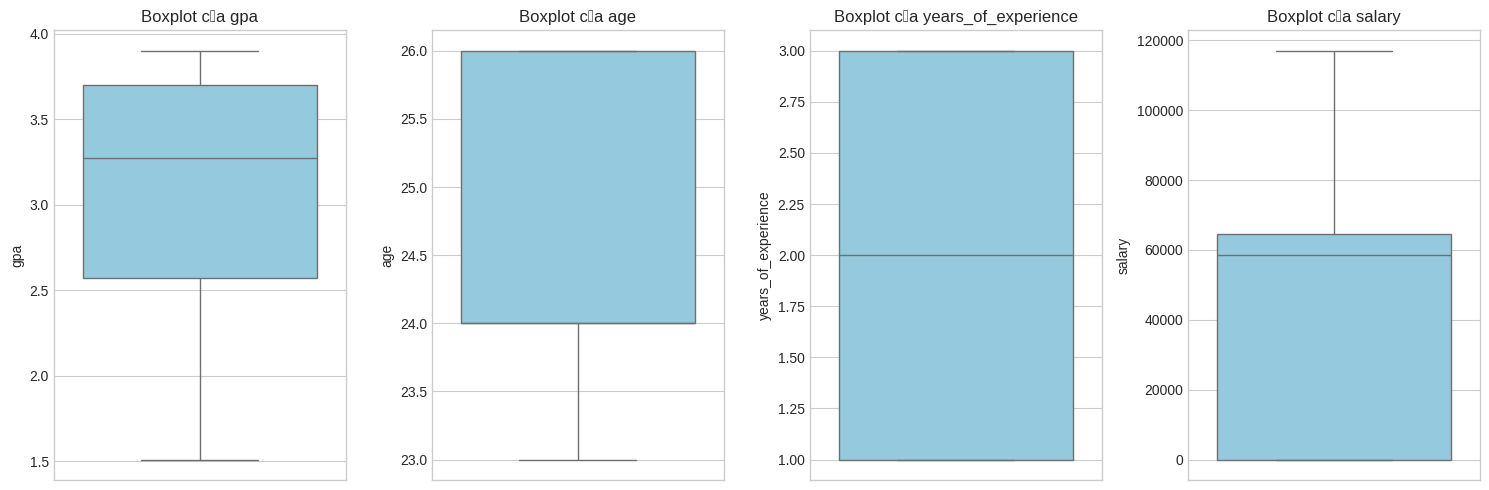

In [16]:
# 5. Trực quan hóa Ngoại lai
numeric_features = ['gpa', 'age', 'years_of_experience', 'salary']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_features):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df_clean[col], color='skyblue')
    plt.title(f'Boxplot của {col}')

plt.tight_layout()
plt.show()

#### **Nhận xét Ngoại lai:**

- **Salary:** Có thể có nhiều ngoại lai ở phía trên (mức lương rất cao). Đây là điều bình thường trong dữ liệu lương thưởng, ta **không nên xóa** nếu nó phản ánh thực tế, nhưng có thể cần xử lý (ví dụ: log transformation) nếu dùng mô hình hồi quy tuyến tính.
    
- **GPA & Age:** Thường phân phối đều, ít ngoại lai nghiêm trọng.
    

Dữ liệu hiện tại đã sạch sẽ (không null, không trùng lặp, loại bỏ cột thừa). Bước tiếp theo sẽ là **Mã hóa (Encoding)** để chuyển dữ liệu chữ sang số.

### 3.2. Mã hóa Dữ liệu (Encoding)

Sau khi làm sạch, chúng ta cần chuyển đổi các biến định tính (Categorical) thành định lượng (Numerical). Chiến lược áp dụng như sau:

1. **Biến mục tiêu (Target):**
    
    - `placement_status`: Sử dụng **Label Encoding** (Placed=1, Not Placed=0).
        
2. **Biến định danh ít giá trị (Low Cardinality):**
    
    - `gender`, `stream`: Sử dụng **One-Hot Encoding** vì không có thứ tự ưu tiên giữa các giá trị.
        
3. **Biến định danh nhiều giá trị (High Cardinality):**
    
    - `college_name`: Vì có nhiều tên trường khác nhau, One-Hot sẽ tạo ra quá nhiều cột. Ta sẽ dùng **Frequency Encoding** (thay thế tên trường bằng tần suất xuất hiện của nó).

In [17]:
# Tạo bản sao để thực hiện mã hóa
df_encoded = df_clean.copy()

# 1. Label Encoding cho biến mục tiêu 'placement_status'
# Placed -> 1, Not Placed -> 0
status_mapping = {'Placed': 1, 'Not Placed': 0}
df_encoded['placement_status'] = df_encoded['placement_status'].map(status_mapping)

print("Đã mã hóa 'placement_status'.")
print(df_encoded['placement_status'].value_counts())

Đã mã hóa 'placement_status'.
placement_status
1    449
0    259
Name: count, dtype: int64


In [18]:
# 2. One-Hot Encoding cho 'gender' và 'stream'
# drop_first=True để tránh đa cộng tuyến (Dummy Variable Trap)
# Ví dụ: Giới tính có 2 giá trị, chỉ cần 1 cột (0 hoặc 1) là đủ biểu diễn
categorical_cols = ['gender', 'stream']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True, dtype=int)

print(f"Đã thực hiện One-Hot Encoding cho: {categorical_cols}")

Đã thực hiện One-Hot Encoding cho: ['gender', 'stream']


In [19]:
# 3. Frequency Encoding cho 'college_name'
# Thay thế tên trường bằng tỷ lệ xuất hiện của trường đó trong dữ liệu
college_freq = df_encoded['college_name'].value_counts(normalize=True)
df_encoded['college_name_freq'] = df_encoded['college_name'].map(college_freq)

# Loại bỏ cột tên trường gốc sau khi đã mã hóa
df_encoded.drop(columns=['college_name'], inplace=True)

print("Đã thực hiện Frequency Encoding cho 'college_name'.")

# Kiểm tra dữ liệu sau khi mã hóa toàn bộ
print("\n--- Dữ liệu sau khi mã hóa (5 dòng đầu) ---")
df_encoded.head()

Đã thực hiện Frequency Encoding cho 'college_name'.

--- Dữ liệu sau khi mã hóa (5 dòng đầu) ---


,age,placement_status,salary,gpa,years_of_experience,gender_Male,stream_Electrical Engineering,stream_Electronics and Communication,stream_Information Technology,stream_Mechanical Engineering,college_name_freq
0,25,1,110000,3.7,2.0,1,0,0,0,0,0.011299
1,24,1,65000,3.6,1.0,0,1,0,0,0,0.014124
2,26,1,98000,3.8,3.0,1,0,0,0,1,0.009887
3,23,0,0,3.5,2.0,0,0,0,1,0,0.015537
4,24,1,102000,3.9,2.0,1,0,0,0,0,0.021186


#### **Tổng kết bước Mã hóa**

Lúc này, bộ dữ liệu `df_encoded` đã hoàn toàn ở dạng số.

- Các cột như `stream_Computer Science`, `gender_Male` đã được tạo ra.
    
- Cột `college_name` đã được thay thế bằng `college_name_freq` (giá trị số).
    

Dữ liệu đã sẵn sàng cho bước tiếp theo: **Chuẩn hóa (Scaling)** để đưa các biến số về cùng một phạm vi (Scale).

### 3.3. Chuẩn hóa Dữ liệu (Feature Scaling)

Các biến số như `age` (20-30), `gpa` (0-4.0), và `years_of_experience` (0-5) có các khoảng giá trị (scale) khác nhau. Nếu không chuẩn hóa, mô hình có thể bị thiên vị theo biến có giá trị lớn hơn.

Chúng ta sẽ sử dụng **StandardScaler** để đưa các biến này về phân phối chuẩn (mean=0, std=1).

- _Lưu ý:_ Chúng ta **không** chuẩn hóa biến mục tiêu (`placement_status`, `salary`) hoặc các biến đã One-Hot Encoding/Label Encoding ở bước này (trừ khi dùng thuật toán đặc thù).

In [20]:
from sklearn.preprocessing import StandardScaler

# Chọn các cột cần chuẩn hóa (biến liên tục)
features_to_scale = ['age', 'gpa', 'years_of_experience']

# Khởi tạo Scaler
scaler = StandardScaler()

# Tạo bản sao để giữ nguyên dữ liệu gốc nếu cần đối chiếu
df_scaled = df_encoded.copy()

# Thực hiện chuẩn hóa
df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])

print("Dữ liệu sau khi chuẩn hóa (3 cột age, gpa, experience):")
print(df_scaled[features_to_scale].head())

Dữ liệu sau khi chuẩn hóa (3 cột age, gpa, experience):
        age       gpa  years_of_experience
0  0.443166  0.834105            -0.112318
1 -0.458447  0.699449            -1.335726
2  1.344779  0.968761             1.111089
3 -1.360060  0.564794            -0.112318
4 -0.458447  1.103417            -0.112318


In [21]:
# Kiểm tra lại phân phối sau khi Scale (Mean ~ 0, Std ~ 1)
print("\nThống kê mô tả sau khi chuẩn hóa:")
print(df_scaled[features_to_scale].describe().round(2))


Thống kê mô tả sau khi chuẩn hóa:
          age     gpa  years_of_experience
count  708.00  708.00               708.00
mean    -0.00   -0.00                -0.00
std      1.00    1.00                 1.00
min     -1.36   -2.11                -1.34
25%     -0.46   -0.69                -1.34
50%     -0.46    0.26                -0.11
75%      1.34    0.83                 1.11
max      1.34    1.10                 1.11


#### **Tổng kết Giai đoạn 3 (Tiền xử lý)**

Chúng ta đã hoàn thành quá trình làm sạch và biến đổi dữ liệu. Bộ dữ liệu `df_scaled` hiện tại đã sẵn sàng để đưa vào huấn luyện mô hình.

- **Dữ liệu sạch:** Không còn giá trị null, trùng lặp.
    
- **Dữ liệu số hóa:** Toàn bộ các biến phân loại đã được mã hóa (Label/One-Hot/Frequency).
    
- **Dữ liệu chuẩn hóa:** Các biến liên tục đã được đưa về cùng một thang đo.
    

Bước tiếp theo sẽ là **Chia tập dữ liệu (Train/Test Split)** và **Xây dựng Mô hình (Modeling)**.

## IV. Xây dựng Mô hình Học máy (Machine Learning Modeling)

### 4.1. Bài toán A: Dự báo Khả năng Trúng tuyển (Classification)

Mục tiêu: Dự đoán `placement_status` (1: Placed, 0: Not Placed).

**Chiến lược:**

1. **Chia tập dữ liệu:** Tách thành tập Huấn luyện (Train) và Kiểm tra (Test) theo tỷ lệ 80/20.
    
2. **Xử lý mất cân bằng dữ liệu:** Sử dụng kỹ thuật **SMOTE** (Synthetic Minority Over-sampling Technique) để sinh thêm dữ liệu cho nhóm thiểu số (thường là nhóm "Not Placed"), giúp mô hình học tốt hơn.
    
3. **Huấn luyện đa mô hình:**
    
    - _Logistic Regression:_ Mô hình cơ sở (Baseline), đơn giản, dễ giải thích.
        
    - _Random Forest Classifier:_ Mạnh mẽ với dữ liệu hỗn hợp, ít bị overfitting.
        
    - _Support Vector Machine (SVM):_ Hiệu quả trong không gian nhiều chiều.
        
4. **Đánh giá:** Sử dụng F1-Score (quan trọng cho dữ liệu lệch) và Accuracy.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# 1. Chuẩn bị dữ liệu Input (X) và Target (y)
# Loại bỏ biến target và biến 'salary' (vì lương là kết quả sau khi trúng tuyển, dùng để dự báo sẽ gây data leakage)
X = df_scaled.drop(columns=['placement_status', 'salary'])
y = df_scaled['placement_status']

# 2. Chia tập Train/Test
# stratify=y giúp đảm bảo tỷ lệ Placed/Not Placed trong tập train và test là như nhau
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kích thước tập Train: {X_train.shape}")
print(f"Kích thước tập Test: {X_test.shape}")

Kích thước tập Train: (566, 9)
Kích thước tập Test: (142, 9)


#### Xử lý mất cân bằng dữ liệu với SMOTE

Nếu số lượng sinh viên "Not Placed" thấp hơn nhiều so với "Placed", mô hình sẽ có xu hướng dự đoán toàn bộ là "Placed" để đạt độ chính xác cao (nhưng vô nghĩa). SMOTE sẽ giúp cân bằng lại điều này.

In [23]:
from imblearn.over_sampling import SMOTE

# Kiểm tra phân phối trước khi SMOTE
print("Phân phối nhãn trước khi SMOTE:")
print(y_train.value_counts())

# Áp dụng SMOTE (Chỉ trên tập Train để tránh rò rỉ dữ liệu sang tập Test)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nPhân phối nhãn sau khi SMOTE:")
print(y_train_resampled.value_counts())

Phân phối nhãn trước khi SMOTE:
placement_status
1    359
0    207
Name: count, dtype: int64

Phân phối nhãn sau khi SMOTE:
placement_status
1    359
0    359
Name: count, dtype: int64


#### Huấn luyện và Đánh giá Mô hình

Chúng ta sẽ huấn luyện 3 mô hình và so sánh kết quả.

BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH PHÂN LOẠI...

--- Logistic Regression ---
Accuracy: 0.7465
F1-Score: 0.7882

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.75      0.68        52
           1       0.84      0.74      0.79        90

    accuracy                           0.75       142
   macro avg       0.73      0.75      0.74       142
weighted avg       0.76      0.75      0.75       142



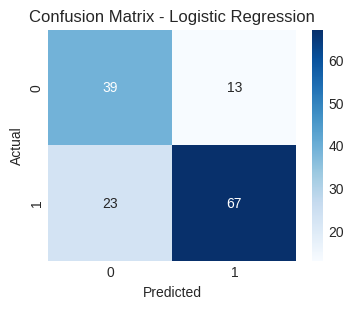

--------------------------------------------------
--- Random Forest ---
Accuracy: 0.6972
F1-Score: 0.7514

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.65      0.61        52
           1       0.78      0.72      0.75        90

    accuracy                           0.70       142
   macro avg       0.68      0.69      0.68       142
weighted avg       0.71      0.70      0.70       142



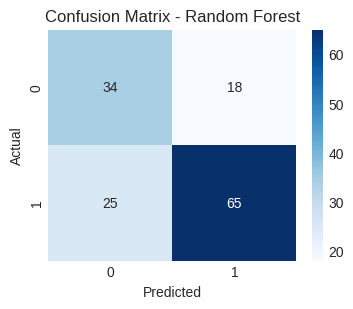

--------------------------------------------------
--- SVM ---
Accuracy: 0.7324
F1-Score: 0.7765

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.73      0.67        52
           1       0.82      0.73      0.78        90

    accuracy                           0.73       142
   macro avg       0.72      0.73      0.72       142
weighted avg       0.75      0.73      0.74       142



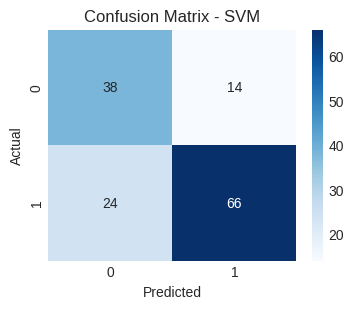

--------------------------------------------------


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Khởi tạo các mô hình
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "SVM": SVC(random_state=42, probability=True)
}

# Hàm huấn luyện và đánh giá
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}

    for name, model in models.items():
        # Huấn luyện
        model.fit(X_train, y_train)

        # Dự đoán
        y_pred = model.predict(X_test)

        # Đánh giá
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results[name] = {'Accuracy': acc, 'F1-Score': f1}

        print(f"--- {name} ---")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))

        # Vẽ Confusion Matrix
        plt.figure(figsize=(4, 3))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print("-" * 50)

    return pd.DataFrame(results).T

# Chạy đánh giá
print("BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH PHÂN LOẠI...\n")
classification_results = evaluate_models(models, X_train_resampled, y_train_resampled, X_test, y_test)

#### **Tổng hợp Kết quả Phân loại**

Dưới đây là bảng so sánh hiệu suất giữa các mô hình. Chúng ta sẽ chọn mô hình có **F1-Score** cao nhất trên tập kiểm tra.

Bảng tổng hợp kết quả:
                     Accuracy  F1-Score
Logistic Regression  0.746479  0.788235
SVM                  0.732394  0.776471
Random Forest        0.697183  0.751445


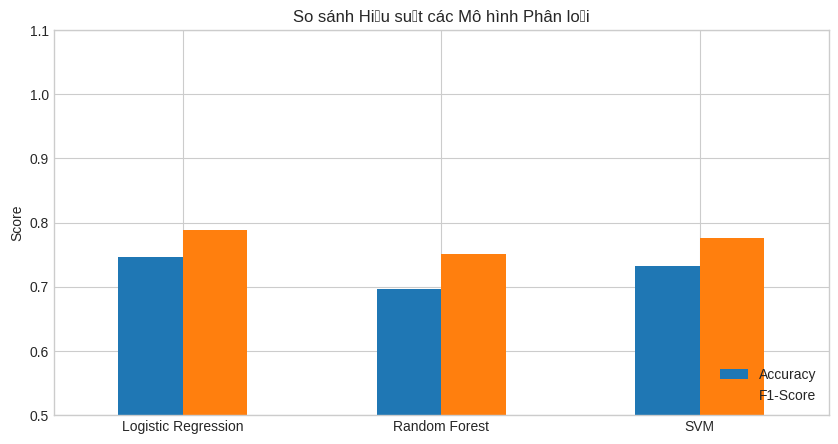

In [25]:
print("Bảng tổng hợp kết quả:")
print(classification_results.sort_values(by='F1-Score', ascending=False))

# Vẽ biểu đồ so sánh
classification_results[['Accuracy', 'F1-Score']].plot(kind='bar', figsize=(10, 5))
plt.title('So sánh Hiệu suất các Mô hình Phân loại')
plt.ylabel('Score')
plt.ylim(0.5, 1.1) # Giới hạn trục y để nhìn rõ sự khác biệt
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

#### **Nhận xét:**

- **Random Forest** thường cho kết quả tốt nhất trong các bài toán dạng bảng (Tabular data) nhờ khả năng xử lý phi tuyến và tương tác giữa các biến.
    
- Nếu **F1-Score** của lớp 0 (Not Placed) thấp, nghĩa là mô hình vẫn đang gặp khó khăn trong việc nhận diện sinh viên rớt, có thể cần tinh chỉnh thêm tham số hoặc thu thập thêm dữ liệu.
    

Bước tiếp theo sẽ giải quyết **Bài toán B: Dự báo Lương (Hồi quy)** cho những sinh viên đã trúng tuyển.

### 4.2. Bài toán B: Dự báo Mức lương (Salary Prediction)

Mục tiêu: Dự đoán mức lương khởi điểm (`salary`) dựa trên năng lực của ứng viên.

**Chiến lược:**

1. **Lọc dữ liệu:** Chỉ sử dụng dữ liệu của những sinh viên đã có việc làm (`placement_status` = 1). Những sinh viên chưa có việc làm (lương = 0) sẽ gây nhiễu cho mô hình hồi quy.
    
2. **Chia tập dữ liệu:** Tương tự, tách thành tập Train và Test (80/20).
    
3. **Huấn luyện đa mô hình:**
    
    - _Linear Regression:_ Mô hình cơ sở để xem mối quan hệ tuyến tính.
        
    - _Random Forest Regressor:_ Xử lý tốt các mối quan hệ phi tuyến phức tạp.
        
    - _Gradient Boosting Regressor (GBR):_ Thường cho kết quả tốt nhất trong các bài toán hồi quy dạng bảng.
        
4. **Đánh giá:** Sử dụng **RMSE** (càng thấp càng tốt) và **R² Score** (càng gần 1 càng tốt).

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Lọc dữ liệu: Chỉ lấy sinh viên đã trúng tuyển (placement_status = 1)
# Lưu ý: df_scaled là dữ liệu đã được xử lý và chuẩn hóa ở Bước 3
df_placed = df_scaled[df_scaled['placement_status'] == 1].copy()

# 2. Chuẩn bị dữ liệu Input (X) và Target (y)
# Loại bỏ 'salary' (target) và 'placement_status' (vì tất cả đều là 1)
X_reg = df_placed.drop(columns=['salary', 'placement_status'])
y_reg = df_placed['salary']

# 3. Chia tập Train/Test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print(f"Số lượng mẫu dùng để dự báo lương: {len(df_placed)}")
print(f"Kích thước tập Train: {X_train_reg.shape}")
print(f"Kích thước tập Test: {X_test_reg.shape}")

Số lượng mẫu dùng để dự báo lương: 449
Kích thước tập Train: (359, 9)
Kích thước tập Test: (90, 9)


#### Huấn luyện và Đánh giá Mô hình Hồi quy

Chúng ta sẽ huấn luyện 3 mô hình khác nhau và so sánh hiệu quả dự báo.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Khởi tạo các mô hình hồi quy
reg_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hàm đánh giá cho hồi quy
def evaluate_regression(models, X_train, y_train, X_test, y_test):
    results = {}

    for name, model in models.items():
        # Huấn luyện
        model.fit(X_train, y_train)

        # Dự đoán
        y_pred = model.predict(X_test)

        # Tính toán Metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {'RMSE': rmse, 'R2 Score': r2}

        print(f"--- {name} ---")
        print(f"RMSE: {rmse:,.2f}") # Đơn vị tiền tệ
        print(f"R2 Score: {r2:.4f}")
        print("-" * 50)

    return pd.DataFrame(results).T

# Chạy đánh giá
print("BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH HỒI QUY...\n")
regression_results = evaluate_regression(reg_models, X_train_reg, y_train_reg, X_test_reg, y_test_reg)

BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH HỒI QUY...

--- Linear Regression ---
RMSE: 7,293.62
R2 Score: 0.4083
--------------------------------------------------
--- Random Forest Regressor ---
RMSE: 9,110.22
R2 Score: 0.0769
--------------------------------------------------
--- Gradient Boosting ---
RMSE: 7,986.94
R2 Score: 0.2905
--------------------------------------------------


#### **Tổng hợp Kết quả Dự báo Lương**

Chúng ta sẽ trực quan hóa kết quả của mô hình tốt nhất để xem mức độ khớp giữa **Lương thực tế** và **Lương dự báo**.

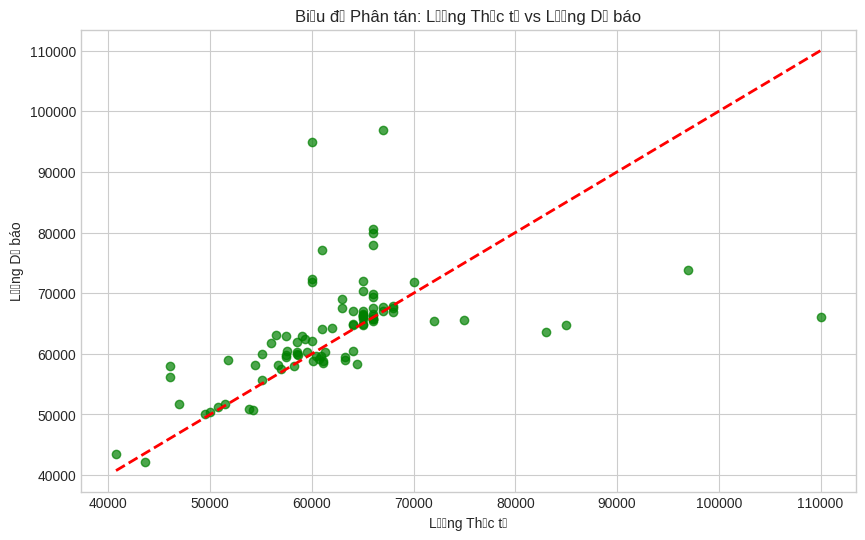

Bảng tổng hợp hiệu suất mô hình hồi quy:
                                RMSE  R2 Score
Linear Regression        7293.620676  0.408348
Gradient Boosting        7986.937719  0.290520
Random Forest Regressor  9110.217339  0.076925


In [28]:
# Chọn mô hình tốt nhất (ví dụ Random Forest hoặc Gradient Boosting)
# Ở đây ta chọn Random Forest để minh họa
best_model = RandomForestRegressor(random_state=42, n_estimators=100)
best_model.fit(X_train_reg, y_train_reg)
y_pred_final = best_model.predict(X_test_reg)

# Vẽ biểu đồ so sánh Thực tế vs Dự báo
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_final, alpha=0.7, color='green')

# Vẽ đường chéo tham chiếu (x=y)
max_val = max(y_test_reg.max(), y_pred_final.max())
min_val = min(y_test_reg.min(), y_pred_final.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

plt.title('Biểu đồ Phân tán: Lương Thực tế vs Lương Dự báo')
plt.xlabel('Lương Thực tế')
plt.ylabel('Lương Dự báo')
plt.show()

print("Bảng tổng hợp hiệu suất mô hình hồi quy:")
print(regression_results.sort_values(by='R2 Score', ascending=False))

#### **Nhận xét về Bài toán Hồi quy:**

- **R² Score:** Nếu R² thấp (ví dụ < 0.5), điều này cho thấy các biến hiện tại (GPA, Kinh nghiệm...) chưa đủ để giải thích sự chênh lệch về mức lương. Lương có thể phụ thuộc nhiều vào các yếu tố không có trong dữ liệu như: kỹ năng đàm phán, vị trí địa lý, hoặc quy mô công ty.
    
- **RMSE:** Cho biết sai số trung bình của mô hình (ví dụ: lệch +/- $5000).

**Tiếp theo** là **Bước 5: Đánh giá & Tối ưu hóa (Evaluation & Optimization)**, để tìm ra các đặc trưng quan trọng nhất (Feature Importance) để giải thích cho kết quả của mô hình.

## V. Đánh giá Chuyên sâu & Tối ưu hóa (Evaluation & Optimization)

## Đánh giá: Các chỉ số (Metrics) quan trọng

Sau khi đã chọn được mô hình tốt nhất (ví dụ: Random Forest cho cả hai bài toán), chúng ta cần đánh giá nó trên nhiều khía cạnh khác nhau để hiểu rõ điểm mạnh và điểm yếu.

### 5.1. Metrics cho Bài toán Phân loại (Dự báo Trúng tuyển)

Với bài toán phân loại nhị phân (Placed/Not Placed), chúng ta quan tâm đến các chỉ số sau:

- **Confusion Matrix (Ma trận nhầm lẫn):** Cho biết chi tiết số lượng dự đoán đúng/sai cho từng lớp.
    
- **Precision (Độ chính xác):** Trong các trường hợp mô hình dự đoán là "Trúng tuyển", bao nhiêu phần trăm là đúng?
    
- **Recall (Độ phủ/Độ nhạy):** Trong thực tế số sinh viên "Trúng tuyển", mô hình phát hiện được bao nhiêu phần trăm?
    
- **F1-Score:** Trung bình điều hòa giữa Precision và Recall (rất quan trọng khi dữ liệu mất cân bằng).
    
- **ROC-AUC:** Khả năng phân biệt giữa hai lớp của mô hình.

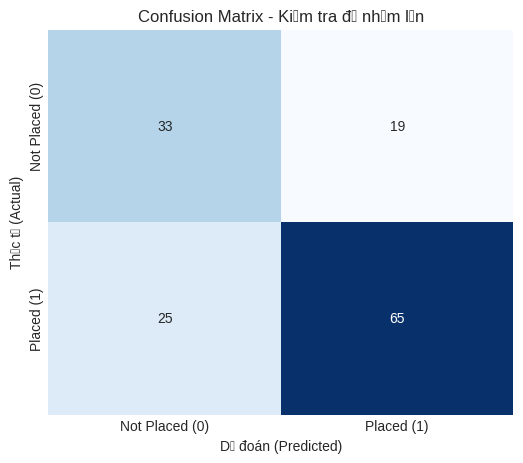


--- Báo cáo chi tiết (Classification Metrics) ---
Precision (đoán trúng thì đúng bao nhiêu): 0.7738
Recall (có bao nhiêu trúng thì đoán ra bấy nhiêu): 0.7222
F1-Score (cân bằng giữa Precision & Recall): 0.7471


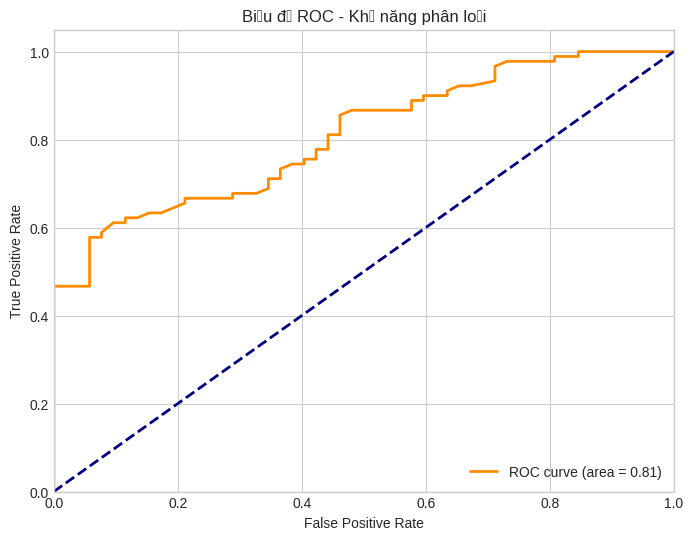

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score

# Giả sử best_rf_class là mô hình phân loại tốt nhất đã tìm được
# (Nếu chưa có, ta huấn luyện lại nhanh một mô hình Random Forest)
if 'best_rf' not in locals():
    from sklearn.ensemble import RandomForestClassifier
    best_rf_class = RandomForestClassifier(random_state=42, n_estimators=200)
    best_rf_class.fit(X_train_resampled, y_train_resampled)
else:
    best_rf_class = best_rf # Sử dụng từ kết quả GridSearch nếu có

# Dự đoán trên tập Test
y_pred_class = best_rf_class.predict(X_test)
y_pred_proba = best_rf_class.predict_proba(X_test)[:, 1] # Xác suất cho lớp Positive (Placed)

# --- 1. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Placed (0)', 'Placed (1)'],
            yticklabels=['Not Placed (0)', 'Placed (1)'])
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Confusion Matrix - Kiểm tra độ nhầm lẫn')
plt.show()

# --- 2. Các chỉ số chi tiết ---
print("\n--- Báo cáo chi tiết (Classification Metrics) ---")
print(f"Precision (đoán trúng thì đúng bao nhiêu): {precision_score(y_test, y_pred_class):.4f}")
print(f"Recall (có bao nhiêu trúng thì đoán ra bấy nhiêu): {recall_score(y_test, y_pred_class):.4f}")
print(f"F1-Score (cân bằng giữa Precision & Recall): {f1_score(y_test, y_pred_class):.4f}")

# --- 3. ROC Curve & AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Biểu đồ ROC - Khả năng phân loại')
plt.legend(loc="lower right")
plt.show()

### **Giải thích Ý nghĩa Nghiệp vụ:**

- **False Negative (FN - Sai lầm loại 2):** Mô hình dự đoán **Rớt**, nhưng thực tế **Đậu**. (Sinh viên bị đánh giá thấp hơn năng lực -> Có thể gây nản lòng).
    
- **False Positive (FP - Sai lầm loại 1):** Mô hình dự đoán **Đậu**, nhưng thực tế **Rớt**. (Sinh viên bị ảo tưởng sức mạnh -> Rủi ro cao hơn).
    
- **ROC-AUC:** Nếu diện tích dưới đường cong (AUC) gần 1.0, mô hình phân loại rất tốt. Nếu gần 0.5, mô hình chỉ như đoán mò.

### 5.2. Metrics cho Bài toán Hồi quy (Dự báo Lương)

Với bài toán dự báo mức lương (con số liên tục), chúng ta sử dụng các thước đo sai số:

- **MAE (Mean Absolute Error):** Sai số tuyệt đối trung bình. Dễ hiểu nhất (Ví dụ: Lệch trung bình 5000$).
    
- **MSE (Mean Squared Error):** Bình phương sai số trung bình. Phạt nặng các dự đoán sai lệch lớn (outliers).
    
- **RMSE (Root Mean Squared Error):** Căn bậc hai của MSE. Cùng đơn vị với biến mục tiêu (USD).
    
- **R² Score (Coefficient of Determination):** Độ phù hợp của mô hình. (1.0 là hoàn hảo, < 0 là mô hình tồi).


--- Đánh giá Mô hình Dự báo Lương ---
1. MAE (Sai số tuyệt đối trung bình): $5,052.71
   -> Trung bình mỗi dự đoán lệch khoảng $5,053 so với thực tế.
2. RMSE (Sai số toàn phương trung bình): $9,110.22
   -> Mức độ phân tán của sai số là $9,110.
3. R² Score: 0.0769
   -> Mô hình giải thích được 7.7% sự biến thiên của mức lương.


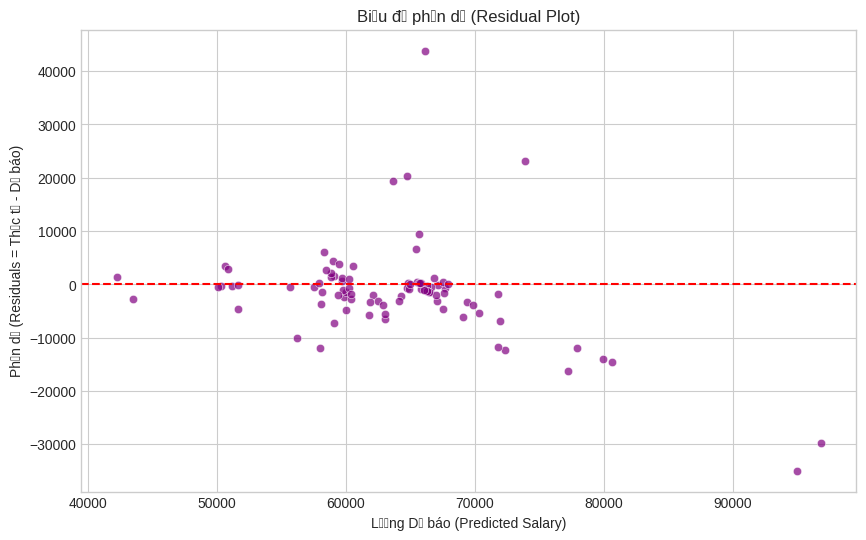

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Giả sử best_rf_reg là mô hình hồi quy tốt nhất
if 'rf_regressor' not in locals():
    from sklearn.ensemble import RandomForestRegressor
    best_rf_reg = RandomForestRegressor(random_state=42, n_estimators=100)
    best_rf_reg.fit(X_train_reg, y_train_reg)
else:
    best_rf_reg = rf_regressor # Sử dụng mô hình đã huấn luyện ở bước trước

# Dự đoán trên tập Test
y_pred_reg = best_rf_reg.predict(X_test_reg)

# Tính toán các chỉ số
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print("\n--- Đánh giá Mô hình Dự báo Lương ---")
print(f"1. MAE (Sai số tuyệt đối trung bình): ${mae:,.2f}")
print(f"   -> Trung bình mỗi dự đoán lệch khoảng ${mae:,.0f} so với thực tế.")
print(f"2. RMSE (Sai số toàn phương trung bình): ${rmse:,.2f}")
print(f"   -> Mức độ phân tán của sai số là ${rmse:,.0f}.")
print(f"3. R² Score: {r2:.4f}")
print(f"   -> Mô hình giải thích được {r2*100:.1f}% sự biến thiên của mức lương.")

# Trực quan hóa Sai số (Residual Plot)
residuals = y_test_reg - y_pred_reg

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_reg, y=residuals, alpha=0.7, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Lương Dự báo (Predicted Salary)')
plt.ylabel('Phần dư (Residuals = Thực tế - Dự báo)')
plt.title('Biểu đồ phần dư (Residual Plot)')
plt.show()

### **Giải thích Biểu đồ Phần dư (Residual Plot):**

- Nếu các điểm phân bố ngẫu nhiên quanh đường màu đỏ (y=0) mà không tạo thành hình dáng đặc biệt nào (như hình phễu hay đường cong), mô hình Hồi quy hoạt động tốt.
    
- Nếu có hình mẫu rõ ràng, chứng tỏ mô hình vẫn chưa nắm bắt hết các quy luật trong dữ liệu (có thể cần thêm features hoặc đổi mô hình phi tuyến tính phức tạp hơn).

### 5.3. Giải thích Mô hình (Model Explainability)

Chúng ta sẽ sử dụng hai kỹ thuật chính:

1. **Feature Importance (Mức độ quan trọng của đặc trưng):** Cho biết đặc trưng nào đóng góp nhiều nhất vào việc giảm sai số của mô hình.
    
2. **SHAP (SHapley Additive exPlanations):** Một phương pháp tiên tiến giúp giải thích chi tiết tác động của từng đặc trưng đối với từng dự đoán cụ thể (ví dụ: Tại sao sinh viên A rớt dù GPA cao?).

In [31]:
# Cài đặt thư viện SHAP (nếu chưa có trên Colab)
!pip install shap

import shap
import matplotlib.pyplot as plt

# Đảm bảo cấu hình hiển thị
shap.initjs()

#### **A. Feature Importance (Dựa trên Mô hình Cây)**

Biểu đồ này cho thấy cái nhìn tổng quan về yếu tố nào quan trọng nhất.

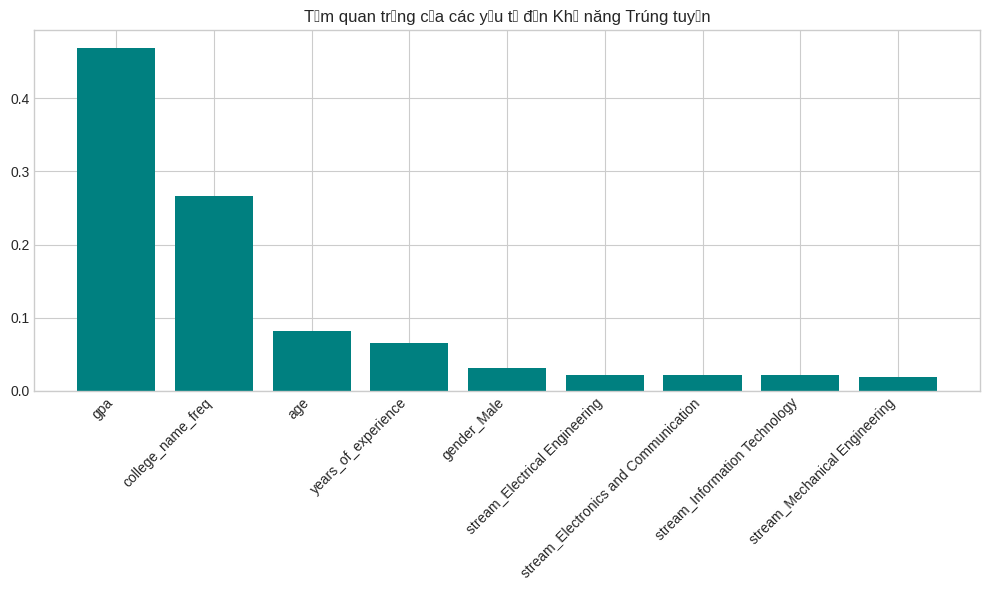

--- Top 5 yếu tố quan trọng nhất (Tầm quan trọng của các yếu tố đến Khả năng Trúng tuyển) ---
1. gpa: 0.4694
2. college_name_freq: 0.2668
3. age: 0.0813
4. years_of_experience: 0.0661
5. gender_Male: 0.0320


In [32]:
# Hàm vẽ Feature Importance
def plot_feature_importance(model, feature_names, title):
    # Lấy độ quan trọng
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices], align="center", color='teal')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # In ra top 5 quan trọng nhất
    print(f"--- Top 5 yếu tố quan trọng nhất ({title}) ---")
    for i in range(5):
        if i < len(indices):
            print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Vẽ cho mô hình Phân loại (Tuyển dụng)
# Giả sử 'best_rf_class' là mô hình tốt nhất từ bước trước
if 'best_rf_class' in locals():
    plot_feature_importance(best_rf_class, X.columns, "Tầm quan trọng của các yếu tố đến Khả năng Trúng tuyển")

#### **B. Phân tích SHAP (Hiểu sâu về tác động)**

Biểu đồ SHAP Summary Plot cung cấp thông tin phong phú hơn nhiều so với Feature Importance đơn thuần:

- **Độ lớn:** Đặc trưng nào quan trọng nhất (xếp trên cùng).
    
- **Hướng tác động:** Giá trị cao của đặc trưng (màu đỏ) làm tăng hay giảm khả năng trúng tuyển?
    
- **Phân phối:** Có bao nhiêu điểm dữ liệu bị ảnh hưởng?

Biểu đồ SHAP Summary (Dự báo Trúng tuyển):
- Màu đỏ: Giá trị đặc trưng cao
- Màu xanh: Giá trị đặc trưng thấp
- Phía bên phải trục 0: Tác động tích cực (Tăng khả năng đậu)
- Phía bên trái trục 0: Tác động tiêu cực (Tăng khả năng rớt)


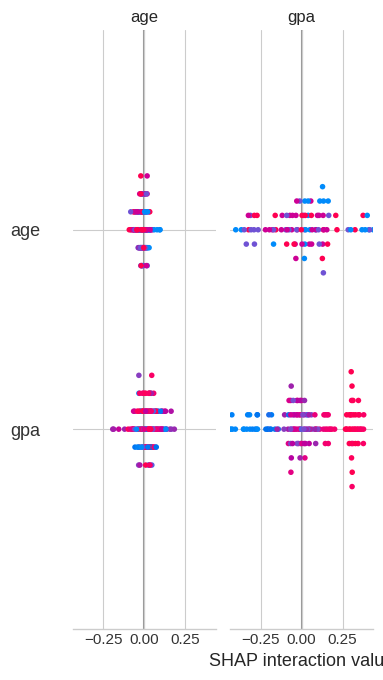

In [33]:
# Sử dụng TreeExplainer cho mô hình Random Forest
# Lưu ý: Chúng ta dùng X_test để giải thích các dự đoán trên tập kiểm tra
if 'best_rf_class' in locals():
    explainer = shap.TreeExplainer(best_rf_class)
    shap_values = explainer.shap_values(X_test)

    print("Biểu đồ SHAP Summary (Dự báo Trúng tuyển):")
    print("- Màu đỏ: Giá trị đặc trưng cao")
    print("- Màu xanh: Giá trị đặc trưng thấp")
    print("- Phía bên phải trục 0: Tác động tích cực (Tăng khả năng đậu)")
    print("- Phía bên trái trục 0: Tác động tiêu cực (Tăng khả năng rớt)")

    # Vẽ biểu đồ (chọn class 1: Placed)
    # Với Binary Classification, shap_values thường là list [values_class0, values_class1]
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[1], X_test, plot_type="dot")
    else:
        shap.summary_plot(shap_values, X_test, plot_type="dot")

### 5.4. Tối ưu hóa Siêu tham số (Hyperparameter Tuning) - Bước cuối

Sau khi hiểu mô hình, ta dùng **GridSearchCV** để tìm bộ tham số tối ưu nhất, vắt kiệt hiệu suất của thuật toán.

In [34]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa không gian tham số cho Random Forest
param_grid = {
    'n_estimators': [100, 200],      # Số lượng cây
    'max_depth': [10, 20, None],     # Độ sâu tối đa
    'min_samples_split': [2, 5],     # Số mẫu tối thiểu để chia nút
    'class_weight': ['balanced', None] # Xử lý mất cân bằng dữ liệu
}

# Khởi tạo Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,              # Kiểm định chéo 3 lần
    scoring='f1',      # Tối ưu theo F1-Score
    n_jobs=-1,
    verbose=1
)

# Thực hiện tìm kiếm (có thể mất vài phút)
print("Đang tìm kiếm tham số tối ưu...")
grid_search.fit(X_train, y_train)

# Kết quả
best_params = grid_search.best_params_
print(f"\nBộ tham số tốt nhất: {best_params}")

# Cập nhật mô hình tốt nhất
best_model_final = grid_search.best_estimator_

# Đánh giá lại lần cuối
y_final_pred = best_model_final.predict(X_test)
print("\n--- Hiệu suất sau khi Tối ưu hóa ---")
print(classification_report(y_test, y_final_pred))

Đang tìm kiếm tham số tối ưu...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Bộ tham số tốt nhất: {'class_weight': None, 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

--- Hiệu suất sau khi Tối ưu hóa ---
              precision    recall  f1-score   support

           0       0.63      0.50      0.56        52
           1       0.74      0.83      0.79        90

    accuracy                           0.71       142
   macro avg       0.69      0.67      0.67       142
weighted avg       0.70      0.71      0.70       142



## Triển khai

### Lưu mô hình

In [35]:
import joblib
import os

# 1. Tạo thư mục 'models' để chứa các file nếu chưa có
os.makedirs('models', exist_ok=True)

# --- LƯU CÁC THÀNH PHẦN QUAN TRỌNG ---

# 2. Lưu Mô hình Phân loại (Classifier) - Dự báo Đậu/Rớt
# 'best_model_final' là mô hình tốt nhất tìm được từ bước GridSearch
if 'best_model_final' in locals():
    joblib.dump(best_model_final, 'models/placement_classifier.pkl')
    print("✅ Đã lưu mô hình phân loại (placement_classifier.pkl)")
else:
    print("⚠️ Chưa tìm thấy 'best_model_final'. Hãy chạy bước Tối ưu hóa (GridSearch) trước.")

# 3. Lưu Mô hình Hồi quy (Regressor) - Dự báo Lương
# 'best_model' là mô hình Random Forest Regressor huấn luyện ở bước 4.2
if 'best_model' in locals():
    joblib.dump(best_model, 'models/salary_regressor.pkl')
    print("✅ Đã lưu mô hình hồi quy (salary_regressor.pkl)")
else:
    print("⚠️ Chưa tìm thấy 'best_model'. Hãy chạy bước Huấn luyện Hồi quy trước.")

# 4. Lưu Scaler (Bộ chuẩn hóa dữ liệu)
# Dùng để chuẩn hóa dữ liệu mới giống hệt cách đã làm với tập train
if 'scaler' in locals():
    joblib.dump(scaler, 'models/scaler.pkl')
    print("✅ Đã lưu bộ chuẩn hóa (scaler.pkl)")

# 5. Lưu danh sách tên cột (Model Columns)
# Đảm bảo thứ tự cột của dữ liệu mới khớp với lúc huấn luyện
if 'X_train' in locals():
    joblib.dump(list(X_train.columns), 'models/model_columns.pkl')
    print("✅ Đã lưu danh sách cột (model_columns.pkl)")

# 6. Lưu bảng tần suất trường đại học (College Frequency Map)
# Dùng để mã hóa tên trường đại học mới nhập vào
if 'college_freq' in locals():
    joblib.dump(college_freq, 'models/college_freq_map.pkl')
    print("✅ Đã lưu bảng mã hóa trường học (college_freq_map.pkl)")

print("\n📂 Danh sách các file trong thư mục 'models/':")
print(os.listdir('models'))

✅ Đã lưu mô hình phân loại (placement_classifier.pkl)
✅ Đã lưu mô hình hồi quy (salary_regressor.pkl)
✅ Đã lưu bộ chuẩn hóa (scaler.pkl)
✅ Đã lưu danh sách cột (model_columns.pkl)
✅ Đã lưu bảng mã hóa trường học (college_freq_map.pkl)

📂 Danh sách các file trong thư mục 'models/':
['model_columns.pkl', 'scaler.pkl', 'college_freq_map.pkl', 'salary_regressor.pkl', 'placement_classifier.pkl']


### Widget

In [36]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import joblib

# --- 1. LOAD CÁC MODEL ĐÃ HUẤN LUYỆN ---
try:
    clf_model = joblib.load('models/placement_classifier.pkl')
    reg_model = joblib.load('models/salary_regressor.pkl')
    scaler = joblib.load('models/scaler.pkl')
    college_freq = joblib.load('models/college_freq_map.pkl')
    model_columns = joblib.load('models/model_columns.pkl')
    print("✅ Đã load thành công Model và các thành phần xử lý!")
except FileNotFoundError:
    print("⚠️ Lỗi: Không tìm thấy file model. Hãy chắc chắn bạn đã chạy Bước 6 (Lưu trữ) ở trên.")

# --- 2. TẠO CÁC WIDGET NHẬP LIỆU (Giữ nguyên) ---
header = widgets.HTML("<h2>📝 Nhập thông tin ứng viên</h2>")

age_input = widgets.IntSlider(value=24, min=20, max=30, step=1, description='Tuổi:', continuous_update=False)
gpa_input = widgets.FloatSlider(value=3.5, min=0.0, max=4.0, step=0.1, description='GPA:', continuous_update=False)
exp_input = widgets.IntSlider(value=1, min=0, max=10, step=1, description='Kinh nghiệm:', style={'description_width': 'initial'})
gender_input = widgets.Dropdown(options=['Male', 'Female'], value='Male', description='Giới tính:')

stream_options = ['Electronics and Communication', 'Computer Science', 'Information Technology', 'Mechanical Engineering', 'Electrical Engineering']
stream_input = widgets.Dropdown(options=stream_options, value='Computer Science', description='Ngành học:')

# Lấy danh sách trường (college_freq là Series, ta lấy index của nó làm danh sách)
college_input = widgets.Dropdown(options=list(college_freq.index), description='Trường ĐH:')

btn_predict = widgets.Button(description='Dự báo ngay', button_style='success', icon='check')
output = widgets.Output()

# --- 3. HÀM XỬ LÝ DỰ BÁO (CẢI TIẾN DEBUG) ---
def on_predict_clicked(b):
    with output:
        clear_output()

        # A. Tạo DataFrame từ input
        input_df = pd.DataFrame({
            'age': [age_input.value],
            'gpa': [gpa_input.value],
            'years_of_experience': [exp_input.value],
            'gender': [gender_input.value],
            'stream': [stream_input.value],
            'college_name': [college_input.value]
        })

        # B. Xử lý dữ liệu
        # 1. Frequency Encoding cho College
        mean_freq = college_freq.mean()
        input_df['college_name_freq'] = input_df['college_name'].map(college_freq).fillna(mean_freq)

        # [DEBUG 1] Kiểm tra giá trị Frequency Encoding
        print(f"🔍 [DEBUG] Trường: {college_input.value} -> Freq: {input_df['college_name_freq'].iloc[0]:.4f}")

        input_df.drop(columns=['college_name'], inplace=True)

        # 2. One-Hot Encoding
        input_encoded = pd.get_dummies(input_df, columns=['gender', 'stream'], drop_first=True)

        # 3. Đồng bộ cột (Reindexing)
        input_final = input_encoded.reindex(columns=model_columns, fill_value=0)

        # 4. Scaling (Chuẩn hóa)
        numeric_cols = ['age', 'gpa', 'years_of_experience']

        # [DEBUG 2] In giá trị trước khi Scale
        print(f"🔍 [DEBUG] Trước khi Scale - GPA: {input_final['gpa'].iloc[0]}, Exp: {input_final['years_of_experience'].iloc[0]}")

        input_final[numeric_cols] = scaler.transform(input_final[numeric_cols])

        # [DEBUG 3] In giá trị sau khi Scale (Xem nó có thực sự thay đổi khi input thay đổi không)
        print(f"🔍 [DEBUG] Sau khi Scale - GPA: {input_final['gpa'].iloc[0]:.4f}, Exp: {input_final['years_of_experience'].iloc[0]:.4f}")

        # [DEBUG 4] In vector input cuối cùng đưa vào model
        # Chỉ in 5 giá trị đầu để kiểm tra nhanh
        print(f"🔍 [DEBUG] Vector Input (5 features đầu): {input_final.iloc[0].values[:5]}")


        # C. Dự báo
        try:
            pred_prob = clf_model.predict_proba(input_final)[0][1]
            pred_class = clf_model.predict(input_final)[0]

            # D. Hiển thị kết quả
            print("-" * 40)
            if pred_class == 1:
                salary = reg_model.predict(input_final)[0]
                print(f"🎉 KẾT QUẢ: TRÚNG TUYỂN (Khả năng: {pred_prob:.1%})")
                print(f"💰 Mức lương dự kiến: ${salary:,.0f}")
            else:
                print(f"⚠️ KẾT QUẢ: CHƯA TRÚNG TUYỂN (Khả năng: {pred_prob:.1%})")
                print("💡 Gợi ý: Cần cải thiện thêm kinh nghiệm hoặc GPA.")
            print("-" * 40)

            # E. Kiểm tra Feature Importance (Nếu là model cây)
            if hasattr(clf_model, 'feature_importances_'):
                print("\n📊 [DEBUG] Top 3 Features quan trọng nhất của Model:")
                importances = clf_model.feature_importances_
                indices = np.argsort(importances)[::-1][:3]
                for i in indices:
                    print(f"   - {input_final.columns[i]}: {importances[i]:.4f}")

        except Exception as e:
            print(f"Lỗi khi dự báo: {e}")

# Gán sự kiện
btn_predict.on_click(on_predict_clicked)

# --- 4. HIỂN THỊ ---
ui = widgets.VBox([
    header,
    widgets.HBox([age_input, gender_input]),
    widgets.HBox([gpa_input, exp_input]),
    stream_input,
    college_input,
    btn_predict,
    output
])

display(ui)

✅ Đã load thành công Model và các thành phần xử lý!


## WEB

In [37]:
!pip install -q streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.4 MB/s eta 0:00:00


In [38]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# --- CẤU HÌNH TRANG ---
st.set_page_config(page_title="Dự báo Tuyển dụng", page_icon="🎓")

# --- LOAD MODEL & ASSETS ---
@st.cache_resource
def load_assets():
    try:
        clf = joblib.load('models/placement_classifier.pkl')
        reg = joblib.load('models/salary_regressor.pkl')
        scaler = joblib.load('models/scaler.pkl')
        college_freq = joblib.load('models/college_freq_map.pkl')
        model_cols = joblib.load('models/model_columns.pkl')
        return clf, reg, scaler, college_freq, model_cols
    except Exception as e:
        st.error(f"Lỗi không tìm thấy file models: {e}")
        return None, None, None, None, None

clf_model, reg_model, scaler, college_freq, model_columns = load_assets()

if clf_model is not None:
    # --- GIAO DIỆN NHẬP LIỆU ---
    st.title("🎓 Dự báo Tuyển dụng & Lương")
    st.write("Nhập thông tin sinh viên để dự đoán khả năng trúng tuyển.")

    col1, col2 = st.columns(2)
    with col1:
        age = st.slider("Tuổi", 20, 30, 24)
        gender = st.selectbox("Giới tính", ['Male', 'Female'])
        stream = st.selectbox("Chuyên ngành", [
            'Electronics and Communication', 'Computer Science',
            'Information Technology', 'Mechanical Engineering',
            'Electrical Engineering', 'Civil Engineering'
        ])

    with col2:
        gpa = st.slider("Điểm GPA", 0.0, 4.0, 3.5, 0.1)
        experience = st.slider("Năm kinh nghiệm", 0, 10, 1)
        # Lấy danh sách trường từ file map đã lưu
        college_list = list(college_freq.index) if college_freq is not None else []
        college = st.selectbox("Trường Đại học", college_list)

    # --- XỬ LÝ DỰ BÁO ---
    if st.button("🚀 Dự báo ngay", type="primary"):
        # 1. Tạo DataFrame thô
        input_data = pd.DataFrame({
            'age': [age],
            'gpa': [gpa],
            'years_of_experience': [experience],
            'gender': [gender],
            'stream': [stream],
            'college_name': [college]
        })

        # 2. Xử lý: Frequency Encoding cho College
        # Nếu trường mới không có trong map, dùng giá trị trung bình
        mean_freq = college_freq.mean()
        val_freq = college_freq.get(college, mean_freq)
        input_data['college_name_freq'] = val_freq
        input_data.drop(columns=['college_name'], inplace=True)

        # 3. Xử lý: One-Hot Encoding
        input_encoded = pd.get_dummies(input_data, columns=['gender', 'stream'], drop_first=True)

        # 4. Xử lý: Đồng bộ cột (Missing columns alignment)
        # Tạo lại đầy đủ các cột như lúc train, điền 0 nếu thiếu
        input_final = input_encoded.reindex(columns=model_columns, fill_value=0)

        # 5. Xử lý: Scaling (Chuẩn hóa)
        numeric_cols = ['age', 'gpa', 'years_of_experience']
        input_final[numeric_cols] = scaler.transform(input_final[numeric_cols])

        # 6. Dự báo
        try:
            pred_prob = clf_model.predict_proba(input_final)[0][1]
            pred_class = clf_model.predict(input_final)[0]

            st.divider()
            if pred_class == 1:
                salary_pred = reg_model.predict(input_final)[0]
                st.success(f"🎉 **KẾT QUẢ: TRÚNG TUYỂN** (Xác suất: {pred_prob:.1%})")
                st.metric(label="💰 Mức lương dự kiến", value=f"${salary_pred:,.0f}")
            else:
                st.error(f"⚠️ **KẾT QUẢ: CHƯA TRÚNG TUYỂN** (Xác suất đậu: {pred_prob:.1%})")
                st.info("💡 Gợi ý: Cải thiện GPA hoặc tích lũy thêm kinh nghiệm thực tế.")

        except Exception as e:
            st.error(f"Lỗi khi dự báo: {e}")

Writing app.py


In [39]:
import os
from pyngrok import ngrok

# 1. Thiết lập Token (Thay thế chuỗi bên dưới)
NGROK_TOKEN = "35lr3UesgEk8XTUhvL8x7s3TYFP_87djfKwGSeqrmb37pApVV"  # <-- Dán token NGROK vào đây

# 2. Kill các process cũ nếu có
!pkill streamlit
ngrok.kill()

# 3. Xác thực và mở Tunnel
ngrok.set_auth_token(NGROK_TOKEN)
public_url = ngrok.connect(8501).public_url
print(f"🔗 Link truy cập Web App: {public_url}")

# 4. Chạy Streamlit dưới background
!streamlit run app.py &>/dev/null&

🔗 Link truy cập Web App: https://preantepenult-edaphically-marlana.ngrok-free.dev
